# _Nested sampling_ avec _dynesty_

## Prior transforms

Le concept de _prior transform_ est un peu moins intuitif que celui d'une distribution à priori (_prior_) comme celle utilisée dans un MCMC. Dans un MCMC, la distribution $\pi(\theta)$ est définie **explicitement** en fonction du vecteur de paramètres $\theta$.

Dans le cas du _nested sampling_, les échantillons sont toujours tirés d'un espace uniforme. Il faut donc spécifier une transformation du cube unitaire en $D$ dimensions vers l'espace de paramètres qui nous intéresse (par exemple, un paramètre uniforme entre -100 et 100, un autre gaussien centré sur 0 avec un écart-type de 10). Pour des paramètres indépendants, il suffit d'utilier la distribution cumulative inverse, plus souvent appelée "fonction quantile" ou encore "_percent point function_", en anglais. Il est aussi possible de définir des corrélations ou des conditions entre les paramètres. La [section dédiée aux prior transforms](https://dynesty.readthedocs.io/en/latest/quickstart.html#prior-transforms) de la documtentation de _dynesty_ donne plus d'information à ce sujet.

Pour explorer un peu plus les _prior transforms_, nous allons considérer deux paramètres: l'un ayant un prior uniforme $U(-10, 10)$ et un autre ayant un prior gaussien $\mathcal{N}(5.0, 1.0)$. En général, un _prior transform_ uniforme est assez simple à implémenter manuellement: il suffit de le re-centrer et de le multiplier pour avoir la bonne largeur (car le point de départ est déjà uniforme, mais sur l'intervalle $U(0, 1)$). Pour la majorité des autres distributions (par exemple une gaussienne ou une distribution uniforme en log), le plus simple sera d'utiliser `scipy.stats` avec la fonction `ppf()`. L'exemple plus bas utilise cette méthode pour la distribution gaussienne.

Pour ce premier exemple, on ne fera aucun échantillonage. Le but est juste de vérifier que nos fonctions de _prior transform_ font ce à quoi on s'attend (en général, c'est une bonne habitude de faire cette vérification la première fois qu'on utilise une distribution si on a un doute).

Commençons donc par définir notre fonction `prior_transform()`.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Options matplotlib
plt.style.use('tableau-colorblind10')
rcParams["font.size"] = 18
rcParams["figure.figsize"] = (9, 6)
rcParams["xtick.direction"] = "in"
rcParams["ytick.right"] = True

In [2]:
import numpy as np
from scipy import stats
from numpy.random import default_rng

def prior_transform(u):
    
    p = np.array(u)
    
    # Prior uniform [-10, 10)
    p[0] = 10. * (2. * u[0] - 1.)
    
    # Prior gaussien (N(5.0, 1.0)
    p[1] = stats.norm.ppf(u[1], loc=5.0, scale=1.0)
    
    return p

Générons d'abord des points sur un carré unitaire et vérifion la distribution avec `corner`.

In [3]:
rng = default_rng()  # Nouvelle interface random de numpy
vals = rng.uniform(0, 1, (2, 10000))

In [4]:
vals.shape

(2, 10000)

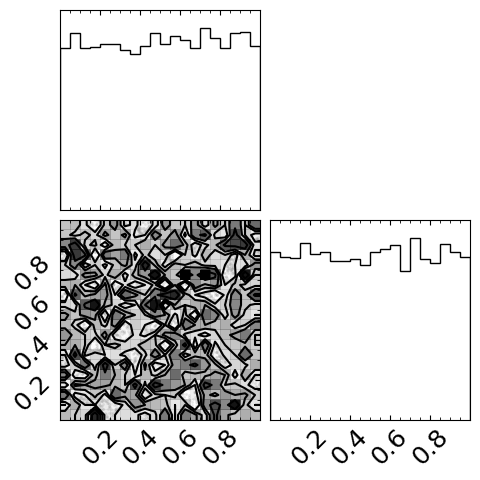

In [5]:
import corner

corner.corner(vals.T);

Maintenant, `prior_transform()` devrait transformer les distributions $U(0, 1)$ vers notre espace de paramètre définit plus haut.

In [6]:
params = prior_transform(vals)

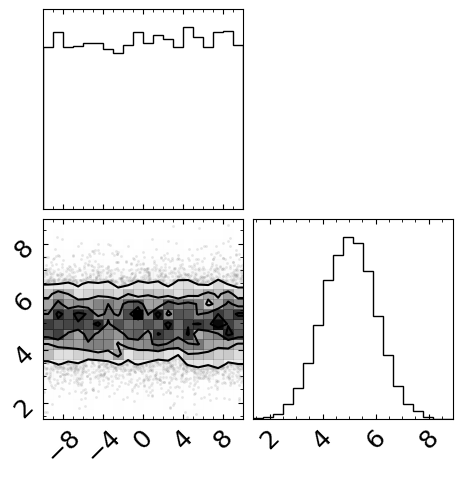

In [7]:
corner.corner(params.T);

Comme prévu, les distributions sont transformées vers nos _priors_ !

## Exemple de comparaison de modèle.

Supposons qu'on obtient des observations quelconques. On veut savoir si les données sont mieux représentées par une parabole ou bien si une droite suffit. On peut utiliser les mêmes données simulées que dans le tutoriel `emcee` de la semaine dernière.

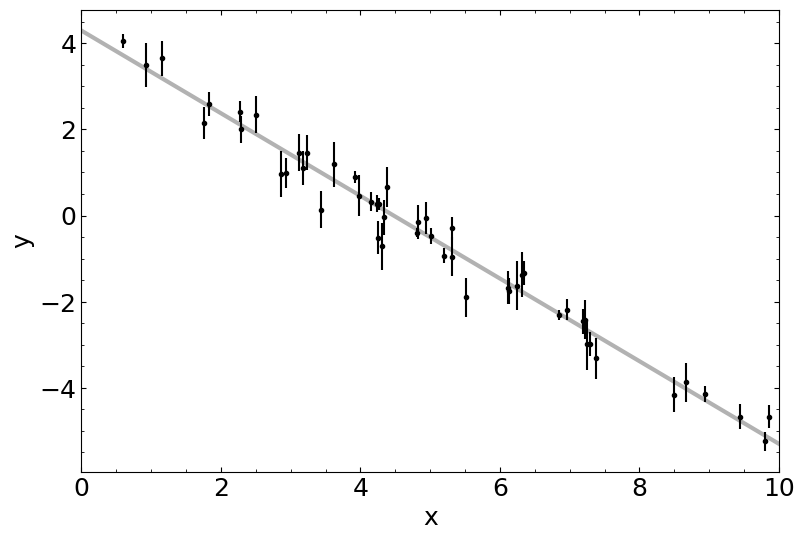

In [8]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Model 1: Droite

On teste d'abord la droite en utilisant les mêmes _priors_ que dans le tutoriel d'emcee (en général on voudrait un _prior_ uniforme en log pour les paramètres d'amplitude, mais une distribution uniforme fera l'affaire ici).

In [9]:
ndim = 2

def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [10]:
def uniform_ptform(u, minval, maxval):
    """Transformation uniforme générale pour éviter de toujours la réécrire"""
    
    assert maxval > minval, "Upper bound should be larger than lower bound"
    
    scale = maxval - minval
    
    return stats.uniform.ppf(u, loc=minval, scale=scale)
    
def ptform_line(u):
    
    p = np.array(u)
    
    # m entre -5.0 et 0.5
    p[0] = uniform_ptform(u[0], -5.0, 0.5)
    # b entre 0 et 10
    p[1] = uniform_ptform(u[1], 0.0, 10.0)
    
    return p

Une fois le modèle et le _prior_ définis, on peut utiliser `dynesty` pour faire un _nested sampling_ dynamique.

In [11]:
import dynesty

# Dynamic nested sampling
sampler_line = dynesty.DynamicNestedSampler(log_likelihood, ptform_line, ndim, logl_args=(x, y, yerr))
sampler_line.run_nested()
results_line = sampler_line.results

15275it [00:15, 1012.59it/s, batch: 7 | bound: 4 | nc: 1 | ncall: 37978 | eff(%): 40.193 | loglstar: 24.656 < 29.080 < 28.826 | logz: 19.520 +/-  0.080 | stop:  0.980]                 


Les graphiques inclus dans dynesty peuvent nous informer sur l'échantillonage et sur l'évolution des points.

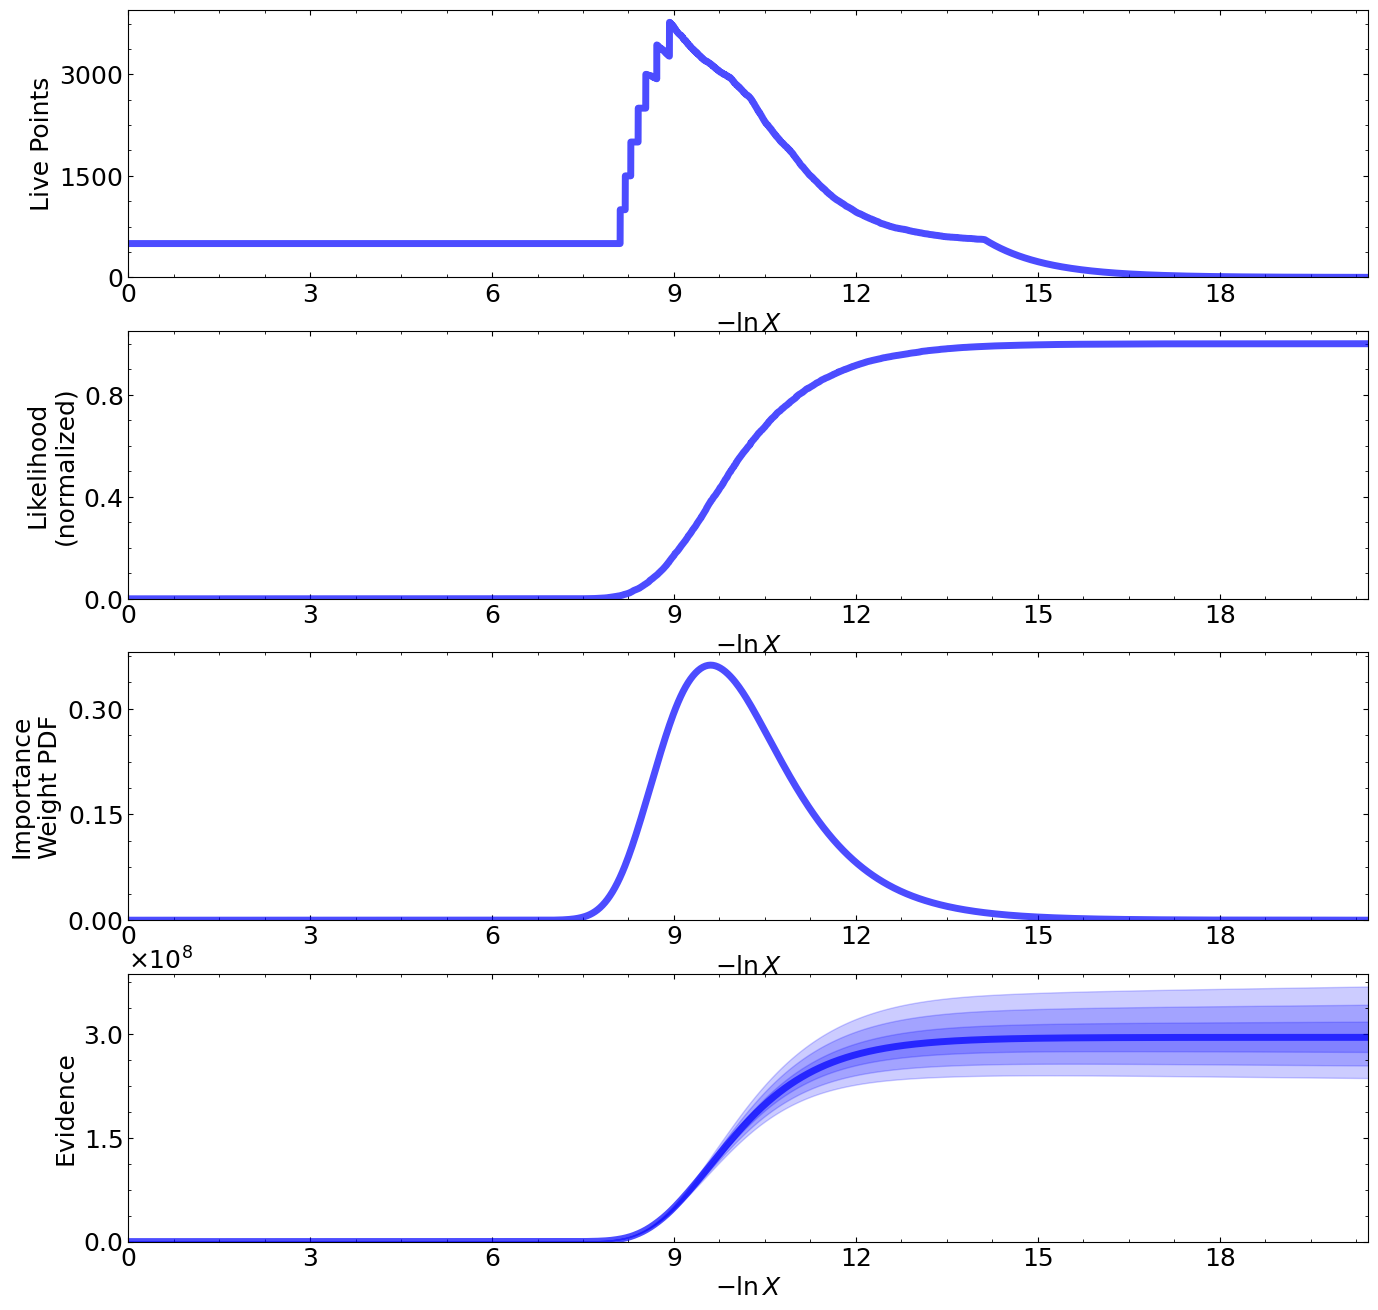

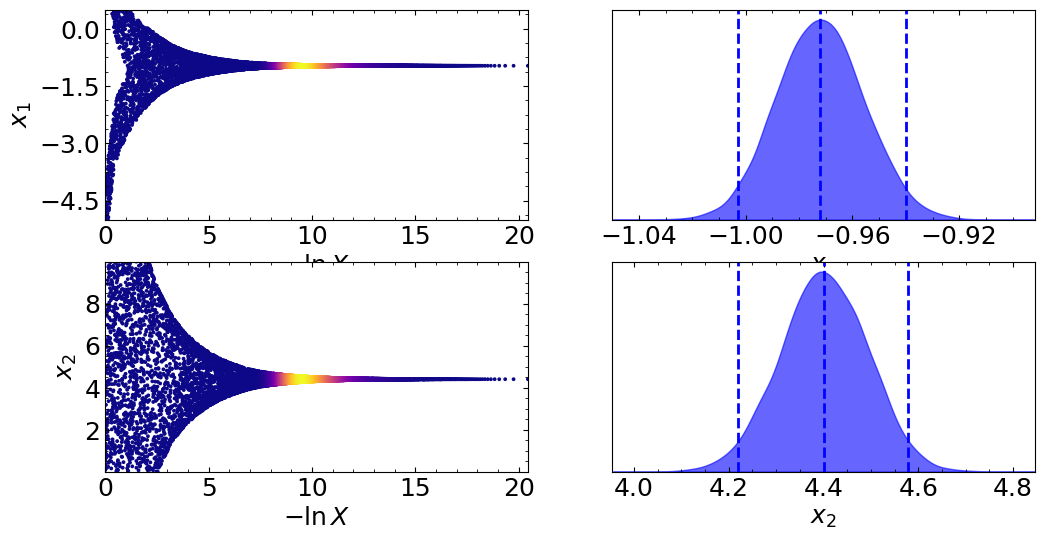

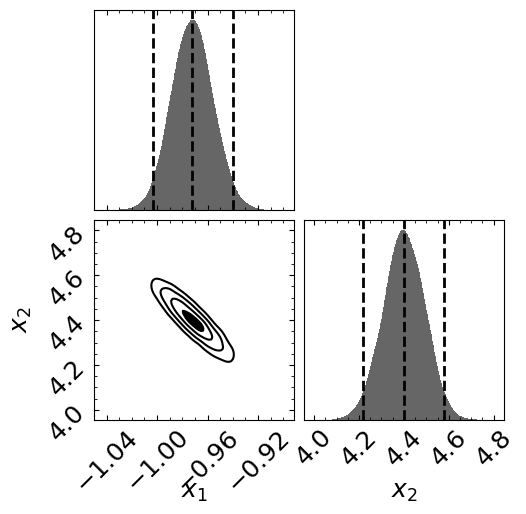

In [12]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(results_line)

tfig, taxes = dyplot.traceplot(results_line)

cfig, caxes = dyplot.cornerplot(results_line)

Ensuite, on peut calculer l'évidence et d'autres informations qui nous intéressent.

In [13]:
from dynesty import utils as dyfunc

# Extraction des résultats
samples = results_line.samples  # échantillons
weights = np.exp(results_line.logwt - results_line.logz[-1])  # poids normalizés

# Evidence, pour la comparaison
logz_line = results_line.logz[-1]

# quantiles pour 16,50,84%
quantiles = [dyfunc.quantile(samps, [0.16, 0.5, 0.84], weights=weights)
             for samps in samples.T]

# Moyenne et covariance pondérées
mean, cov = dyfunc.mean_and_cov(samples, weights)

In [14]:
quantiles = np.array(quantiles)
for i in range(ndim):
    print(quantiles[i, 1], "+", quantiles[i, 2] - quantiles[i, 1], "-", quantiles[i, 1] - quantiles[i, 0])

-0.9721597958169014 + 0.016247297108363146 - 0.016060668822808988
4.400708992099207 + 0.09145517160850147 - 0.09033761410034646


In [15]:
m_line, b_line = quantiles[:, 1]

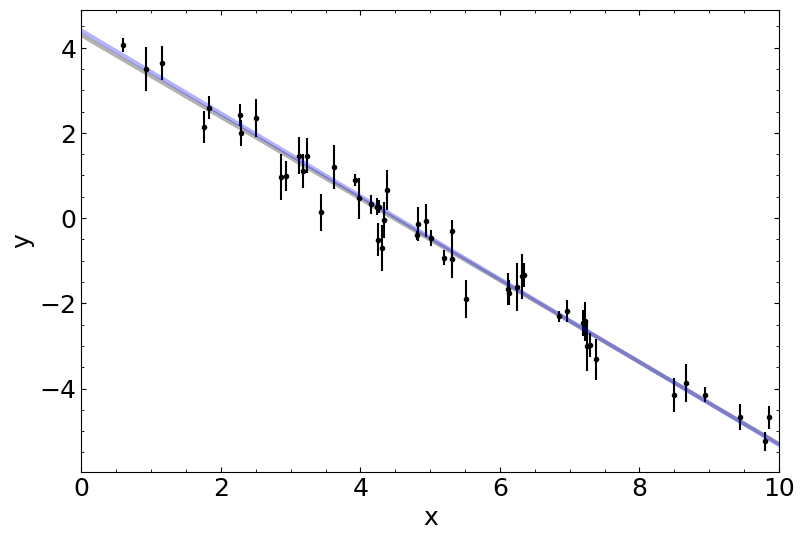

In [16]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.plot(x0,  m_line* x0 + b_line, "b", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Model 2: Parabole
On peut maintenant répéter toute la procédure avec une parabole au lieu d'une droite. Par inspection visuell, il semble que garder le premier coefficient entre -0.1 et 0.1 soit bien suffisant. On utilisera donc ce _prior_ uniforme.

In [17]:
ndim = 3

def log_likelihood(theta, x, y, yerr):
    # Model mis à jour avec un coeffcient quadratique
    a, m, b = theta
    model = a * x ** 2 + m * x + b
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [18]:
def ptform(u):
    
    p = np.array(u)
    
    # a entre -0.1 et 0.1
    p[0] = uniform_ptform(u[0], -0.1, 0.1)
    # m entre -5.0 et 0.5
    p[1] = uniform_ptform(u[1], -5.0, 0.5)
    # b entre 0 et 10
    p[2] = uniform_ptform(u[1], 0.0, 10.0)
    
    return p

In [19]:
import dynesty

# Dynamic nested sampling
sampler_para = dynesty.DynamicNestedSampler(log_likelihood, ptform, ndim, logl_args=(x, y, yerr))
sampler_para.run_nested()
results_para = sampler_para.results

16552it [00:20, 801.67it/s, batch: 8 | bound: 4 | nc: 1 | ncall: 46190 | eff(%): 35.484 | loglstar: -23.077 < -18.179 < -18.535 | logz: -27.767 +/-  0.075 | stop:  0.883]               


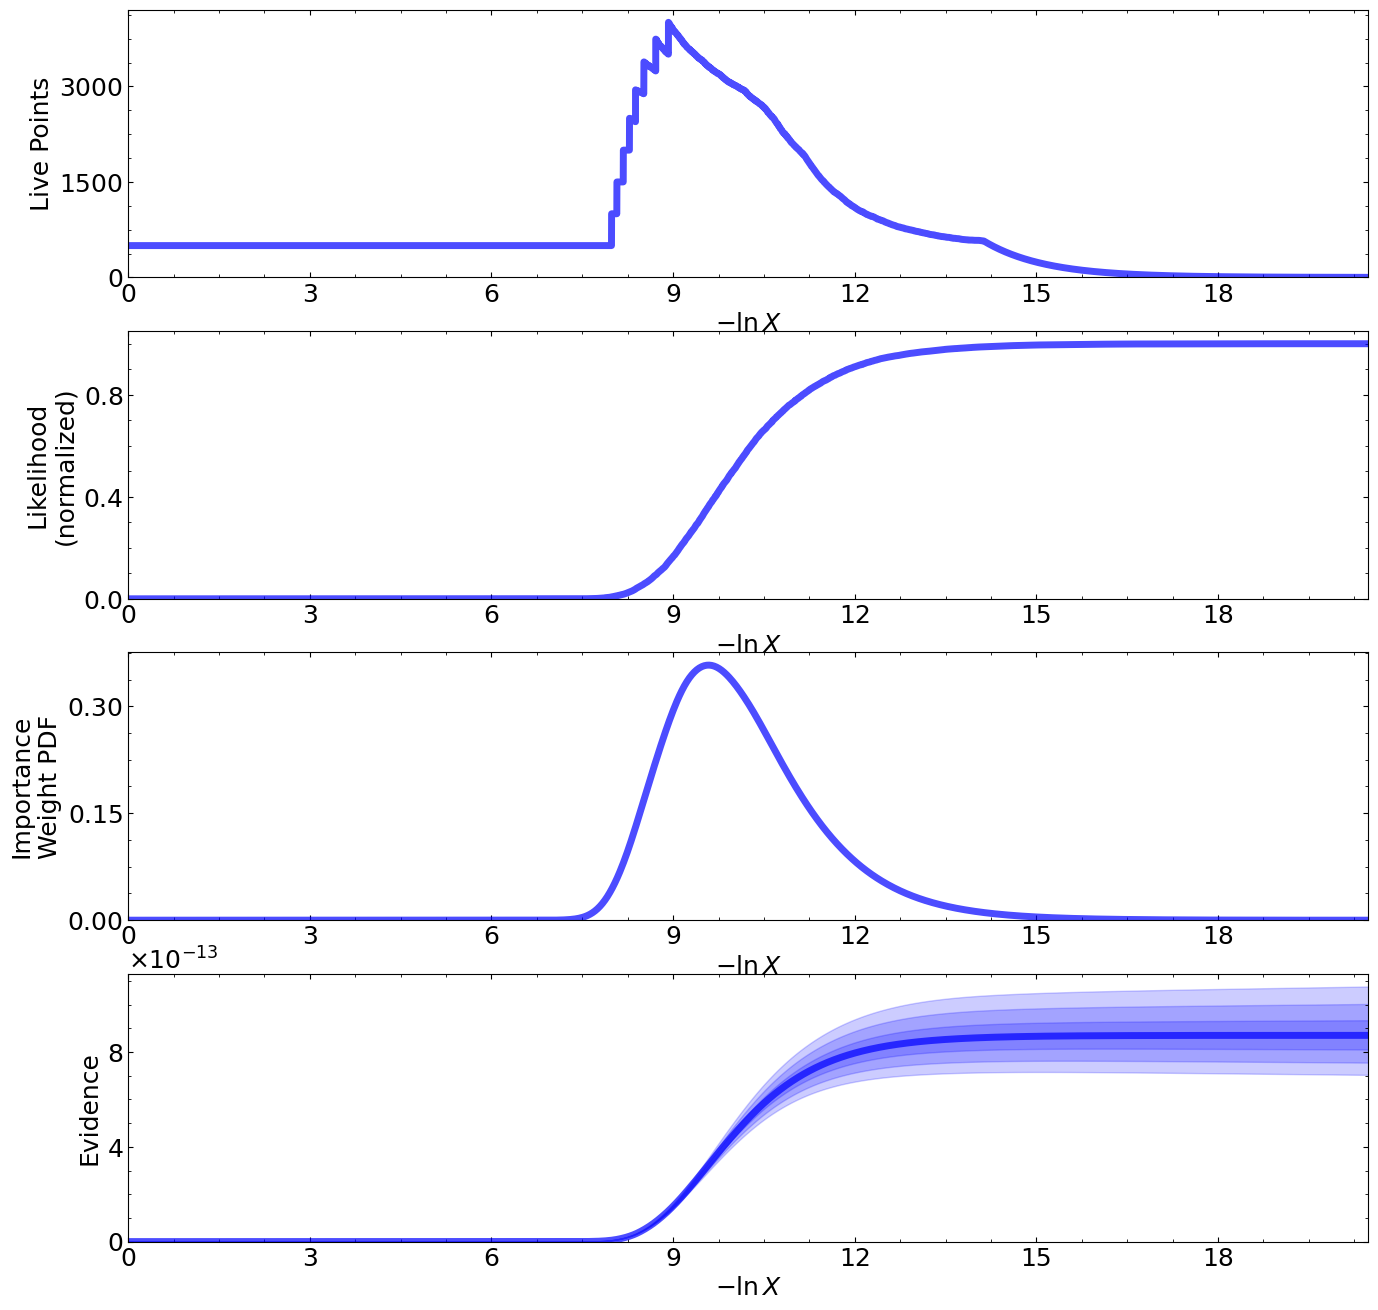

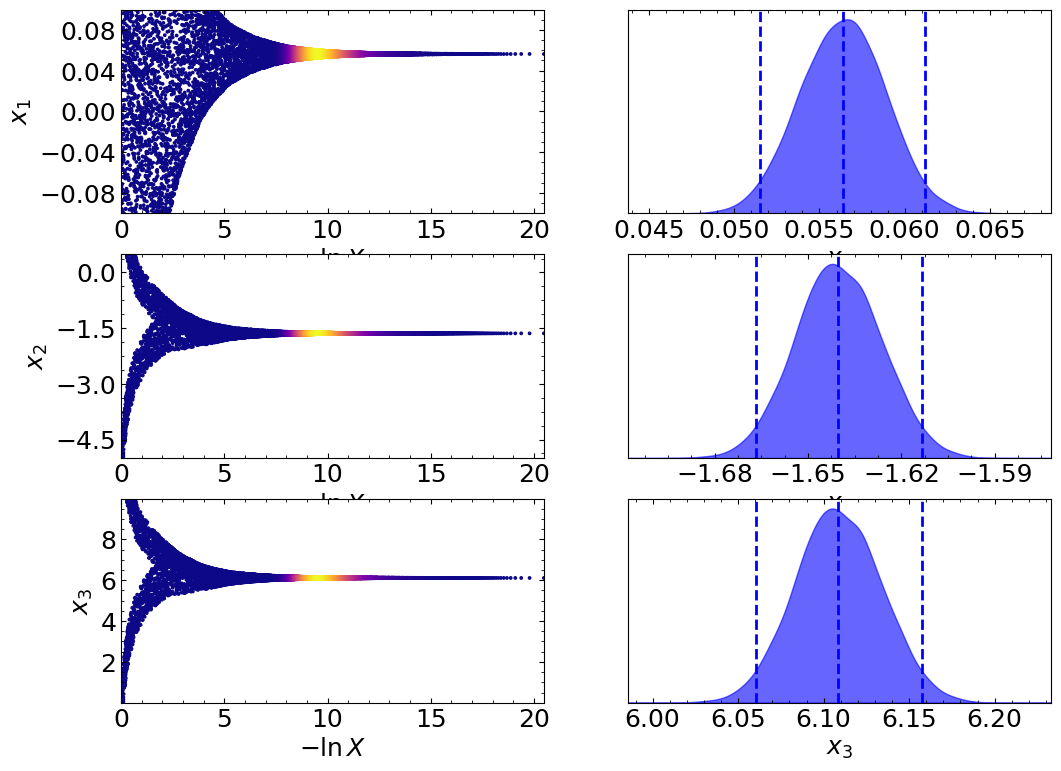

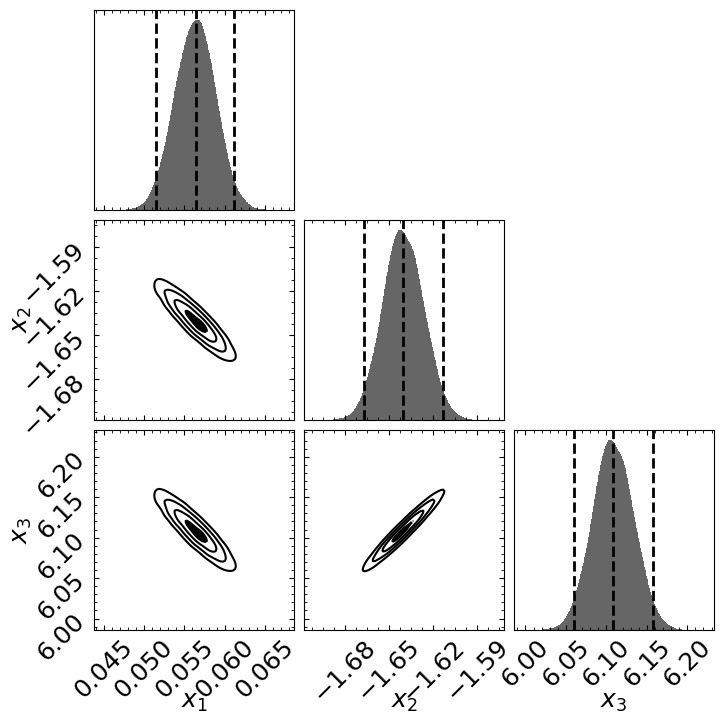

In [20]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(results_para)

tfig, taxes = dyplot.traceplot(results_para)

cfig, caxes = dyplot.cornerplot(results_para)

In [21]:
from dynesty import utils as dyfunc

# Extraction des résultats
samples = results_para.samples  # échantillons
weights = np.exp(results_para.logwt - results_para.logz[-1])  # poids normalizés

logz_para = results_para.logz[-1]

# quantiles pour 10%-90%
quantiles = [dyfunc.quantile(samps, [0.16, 0.5, 0.84], weights=weights)
             for samps in samples.T]

# Moyenne et covariance pondérées
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Re-échantillonnage
samples_equal = dyfunc.resample_equal(samples, weights)

In [22]:
quantiles = np.array(quantiles)
for i in range(ndim):
    print(quantiles[i, 1], "+", quantiles[i, 2] - quantiles[i, 1], "-", quantiles[i, 1] - quantiles[i, 0])

0.05638667699124485 + 0.0024300641679141297 - 0.0025390117572902035
-1.6404929845925358 + 0.014064110208697356 - 0.013357519286753217
6.108194573468117 + 0.025571109470359232 - 0.02428639870318694


In [23]:
a_para, m_para, b_para = quantiles[:, 1]

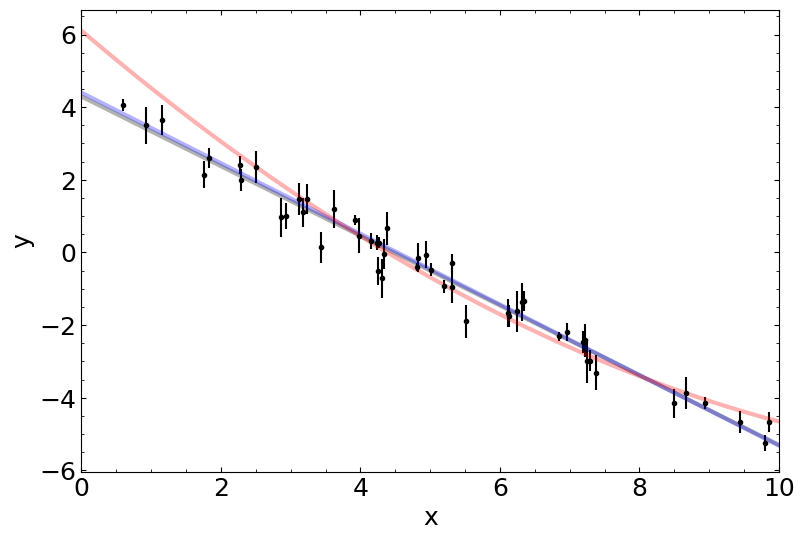

In [24]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.plot(x0,  m_line* x0 + b_line, "b", alpha=0.3, lw=3)
plt.plot(x0,  a_para * x0**2 + m_para* x0 + b_para, "r", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Comparaison des modèles

On peut maintenat utiliser le tableau de Trotta (2008) pour comparer les modèles:

<img src="table1_trotta.png" width=500 height=400 />

Grâce aux évidences calculées ci-haut, on a:

In [25]:
print(f"ln(B01) = {logz_line - logz_para}")

ln(B01) = 47.2738167196832


Selon le tableau, on a une très forte évidence en faveur de la droite par rapport à la parabole. Dans ce cas-ci ce n'est pas suprenant comme les donnés ont été générées à partir d'une droite !